# Imports

In [1]:
import os
import pandas as pd
import numpy as np
from collections import Counter
#--------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
#--------------------------------------------------------------------------------
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.optimizers import Adamax, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Data Loading

In [2]:
training_dir = [
    "/kaggle/input/brain-tumor-mri-dataset/Training"
]

data = []

for dir in training_dir:

        for subdir, _, files in os.walk(dir):
            label = os.path.basename(subdir)  
            for file in files:
                file_path = os.path.join(subdir, file)
                data.append([file_path, label])
                
train_df = pd.DataFrame(data, columns=['file_path', 'label'])

train_df

,file_path,label
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [3]:
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df

,file_path,label
0,/kaggle/input/brain-tumor-mri-dataset/Training...,notumor
1,/kaggle/input/brain-tumor-mri-dataset/Training...,meningioma
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
4,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,meningioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


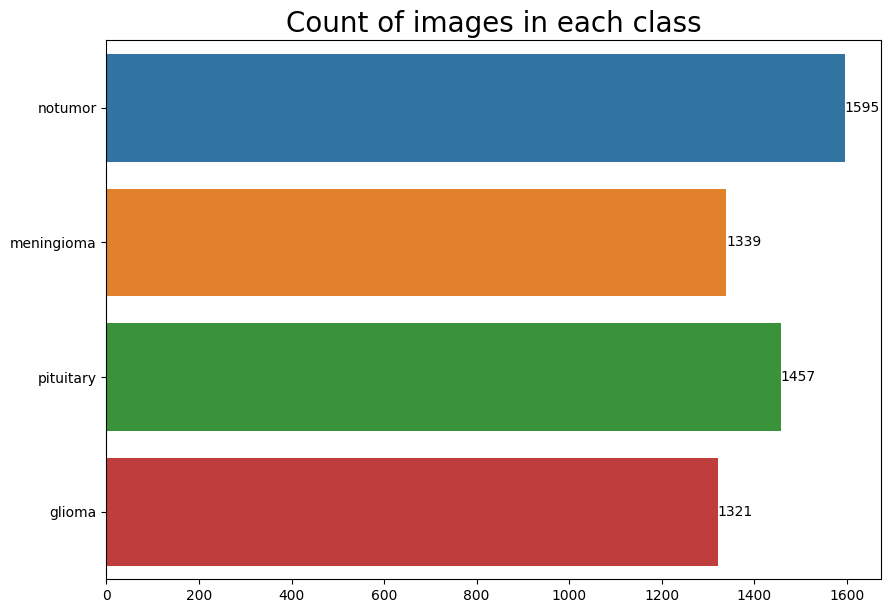

In [4]:
plt.figure(figsize=(10,7))
ax = sns.countplot(data=train_df , y=train_df['label'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

In [5]:
datagen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2),
                            validation_split = 0.2)
train_generator = datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'file_path',
    y_col = 'label',
    target_size = (224, 224),
    batch_size = 64,
    seed = 42,
    subset = 'training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'file_path',
    y_col = 'label',
    target_size = (224, 224),
    batch_size = 64,
    seed = 42,
    subset = 'validation'
)

Found 4570 validated image filenames belonging to 4 classes.
Found 1142 validated image filenames belonging to 4 classes.


In [6]:
datagen = ImageDataGenerator(rescale=1/255,)

test_generator = datagen.flow_from_directory(
    directory = '/kaggle/input/brain-tumor-mri-dataset/Testing',
    target_size = (224, 224),
    batch_size = 64,
    seed = 42,
    shuffle = False,
)

Found 1311 images belonging to 4 classes.


In [7]:
label_dict = {v: k for k, v in train_generator.class_indices.items()}
label_dict

{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

In [8]:
class_labels = list(train_generator.class_indices.keys())

# Count images per class in train_generator
train_class_counts = Counter(train_generator.classes)
train_class_counts = {class_labels[i]: count for i, count in train_class_counts.items()}

# Count images per class in validation_generator
validation_class_counts = Counter(validation_generator.classes)
validation_class_counts = {class_labels[i]: count for i, count in validation_class_counts.items()}

# Print the results
print("Training set class counts:", train_class_counts)
print("\nValidation set class counts:", validation_class_counts)

Training set class counts: {'glioma': 1053, 'pituitary': 1137, 'notumor': 1297, 'meningioma': 1083}

Validation set class counts: {'notumor': 298, 'meningioma': 256, 'pituitary': 320, 'glioma': 268}


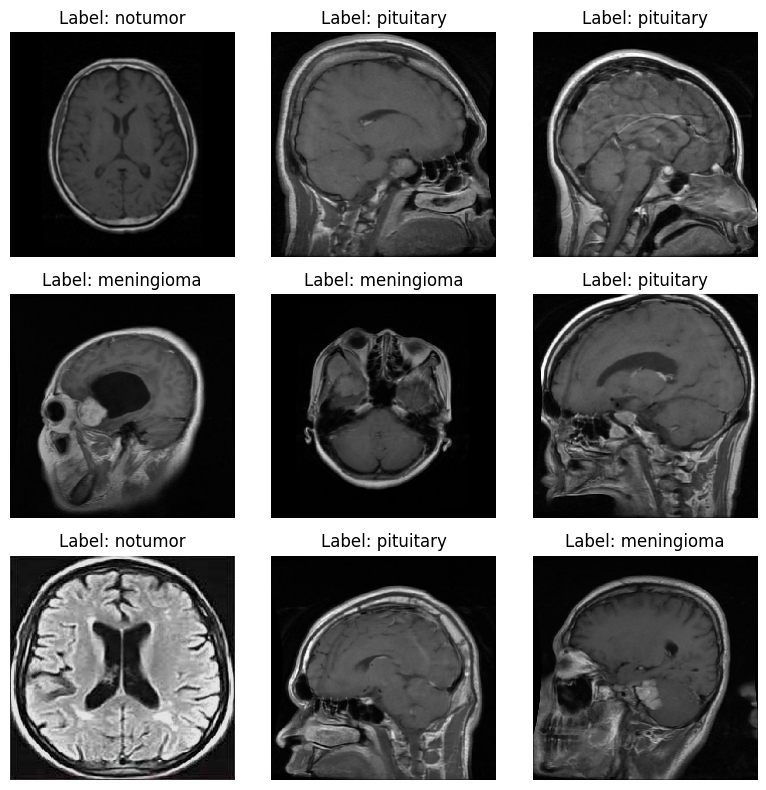

In [9]:
images, labels = next(train_generator)

num_images = 9  

fig, axes = plt.subplots(3, 3, figsize=(8, 8))  
axes = axes.flatten()  

for i in range(num_images):
    img = images[i]
    
    img = (img * 255).astype(np.uint8)
    
    axes[i].imshow(img)  
    axes[i].axis('off')
    name = np.argmax(labels[i])
    class_name = label_dict[name]
    axes[i].set_title('Label: {}'.format(class_name))

plt.tight_layout()
plt.show()


# Model Making

> <h2>1. Xception

In [10]:
img_shape = (224, 224, 3)

In [11]:
early_stopping = EarlyStopping(
    patience=10,
    min_delta=0,
    # mode=min,
    monitor='val_loss',
    verbose=0,
    restore_best_weights=True,
    baseline=None
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',       
    factor=0.5,               
    patience=3,               
    min_lr=1e-7               
)

In [12]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    precision = history.history["precision"]
    val_precision = history.history["val_precision"]
    
    recall = history.history["recall"]
    val_recall = history.history["val_recall"]
    
    auc = history.history["auc"]
    val_auc = history.history["val_auc"]
    
    epochs = range(len(loss))
    
    plt.figure(figsize=(20, 15))
    plt.style.use('ggplot')
    
    # Plot Loss
    plt.subplot(3, 2, 1)
    plt.plot(epochs, loss, 'bo-', label="Train Loss")
    plt.plot(epochs, val_loss, 'o-', color='orange', label="Val Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(3, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label="Train Accuracy")
    plt.plot(epochs, val_accuracy, 'o-', color='orange', label="Val Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    
    # Plot Precision
    plt.subplot(3, 2, 3)
    plt.plot(epochs, precision, 'bo-', label="Train Precision")
    plt.plot(epochs, val_precision, 'o-', color='orange', label="Val Precision")
    plt.title("Precision")
    plt.xlabel("Epochs")
    plt.legend()
    
    # Plot Recall
    plt.subplot(3, 2, 4)
    plt.plot(epochs, recall, 'bo-', label="Train Recall")
    plt.plot(epochs, val_recall, 'o-', color='orange', label="Val Recall")
    plt.title("Recall")
    plt.xlabel("Epochs")
    plt.legend()
    
    # Plot AUC
    plt.subplot(3, 2, 5)
    plt.plot(epochs, auc, 'bo-', label="Train AUC")
    plt.plot(epochs, val_auc, 'o-', color='orange', label="Val AUC")
    plt.title("AUC")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.tight_layout()
    plt.style.use('default')
    plt.show()


In [14]:


base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False
    
model = tf.keras.models.Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(name='precision'),
                        Recall(name='recall'),
                       AUC(name='auc')])

model.build(input_shape=(None, 224, 224, 3))
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

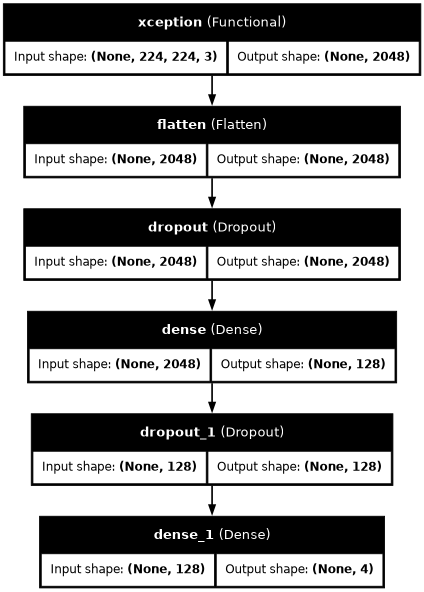

In [15]:
tf.keras.utils.plot_model(model, to_file='Xception.png',show_shapes=True, dpi = 60, show_layer_names = True)

In [16]:
%%time
history = model.fit(train_generator, epochs = 50, validation_data = validation_generator, callbacks = [early_stopping, reduce_lr])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731390624.638603     106 service.cc:145] XLA service 0x7c7d8c002a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731390624.638680     106 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-11-12 05:50:51.421910: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[728,728,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,728,28,28]{3,2,1,0}, f32[64,728,28,28]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backen

72/72 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.7307 - auc: 0.8861 - loss: 0.8052 - precision: 0.7742 - recall: 0.6204 - val_accuracy: 0.8074 - val_auc: 0.9441 - val_loss: 0.7402 - val_precision: 0.8188 - val_recall: 0.7995 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 541ms/step - accuracy: 0.9782 - auc: 0.9980 - loss: 0.0701 - precision: 0.9799 - recall: 0.9770 - val_accuracy: 0.9116 - val_auc: 0.9839 - val_loss: 0.2975 - val_precision: 0.9152 - val_recall: 0.9072 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 544ms/step - accuracy: 0.9918 - auc: 0.9997 - loss: 0.0231 - precision: 0.9925 - recall: 0.9899 - val_accuracy: 0.9378 - val_auc: 0.9930 - val_loss: 0.2020 - val_precision: 0.9402 - val_recall: 0.9370 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 542ms/step - accuracy: 0.9925 - auc: 0.9993 - loss: 0.0255 - precision: 0.9934 - recall: 0.9923 - val_accuracy: 0.9501 - val_auc: 0.9901 - val_loss: 0.1933 - val_precisio

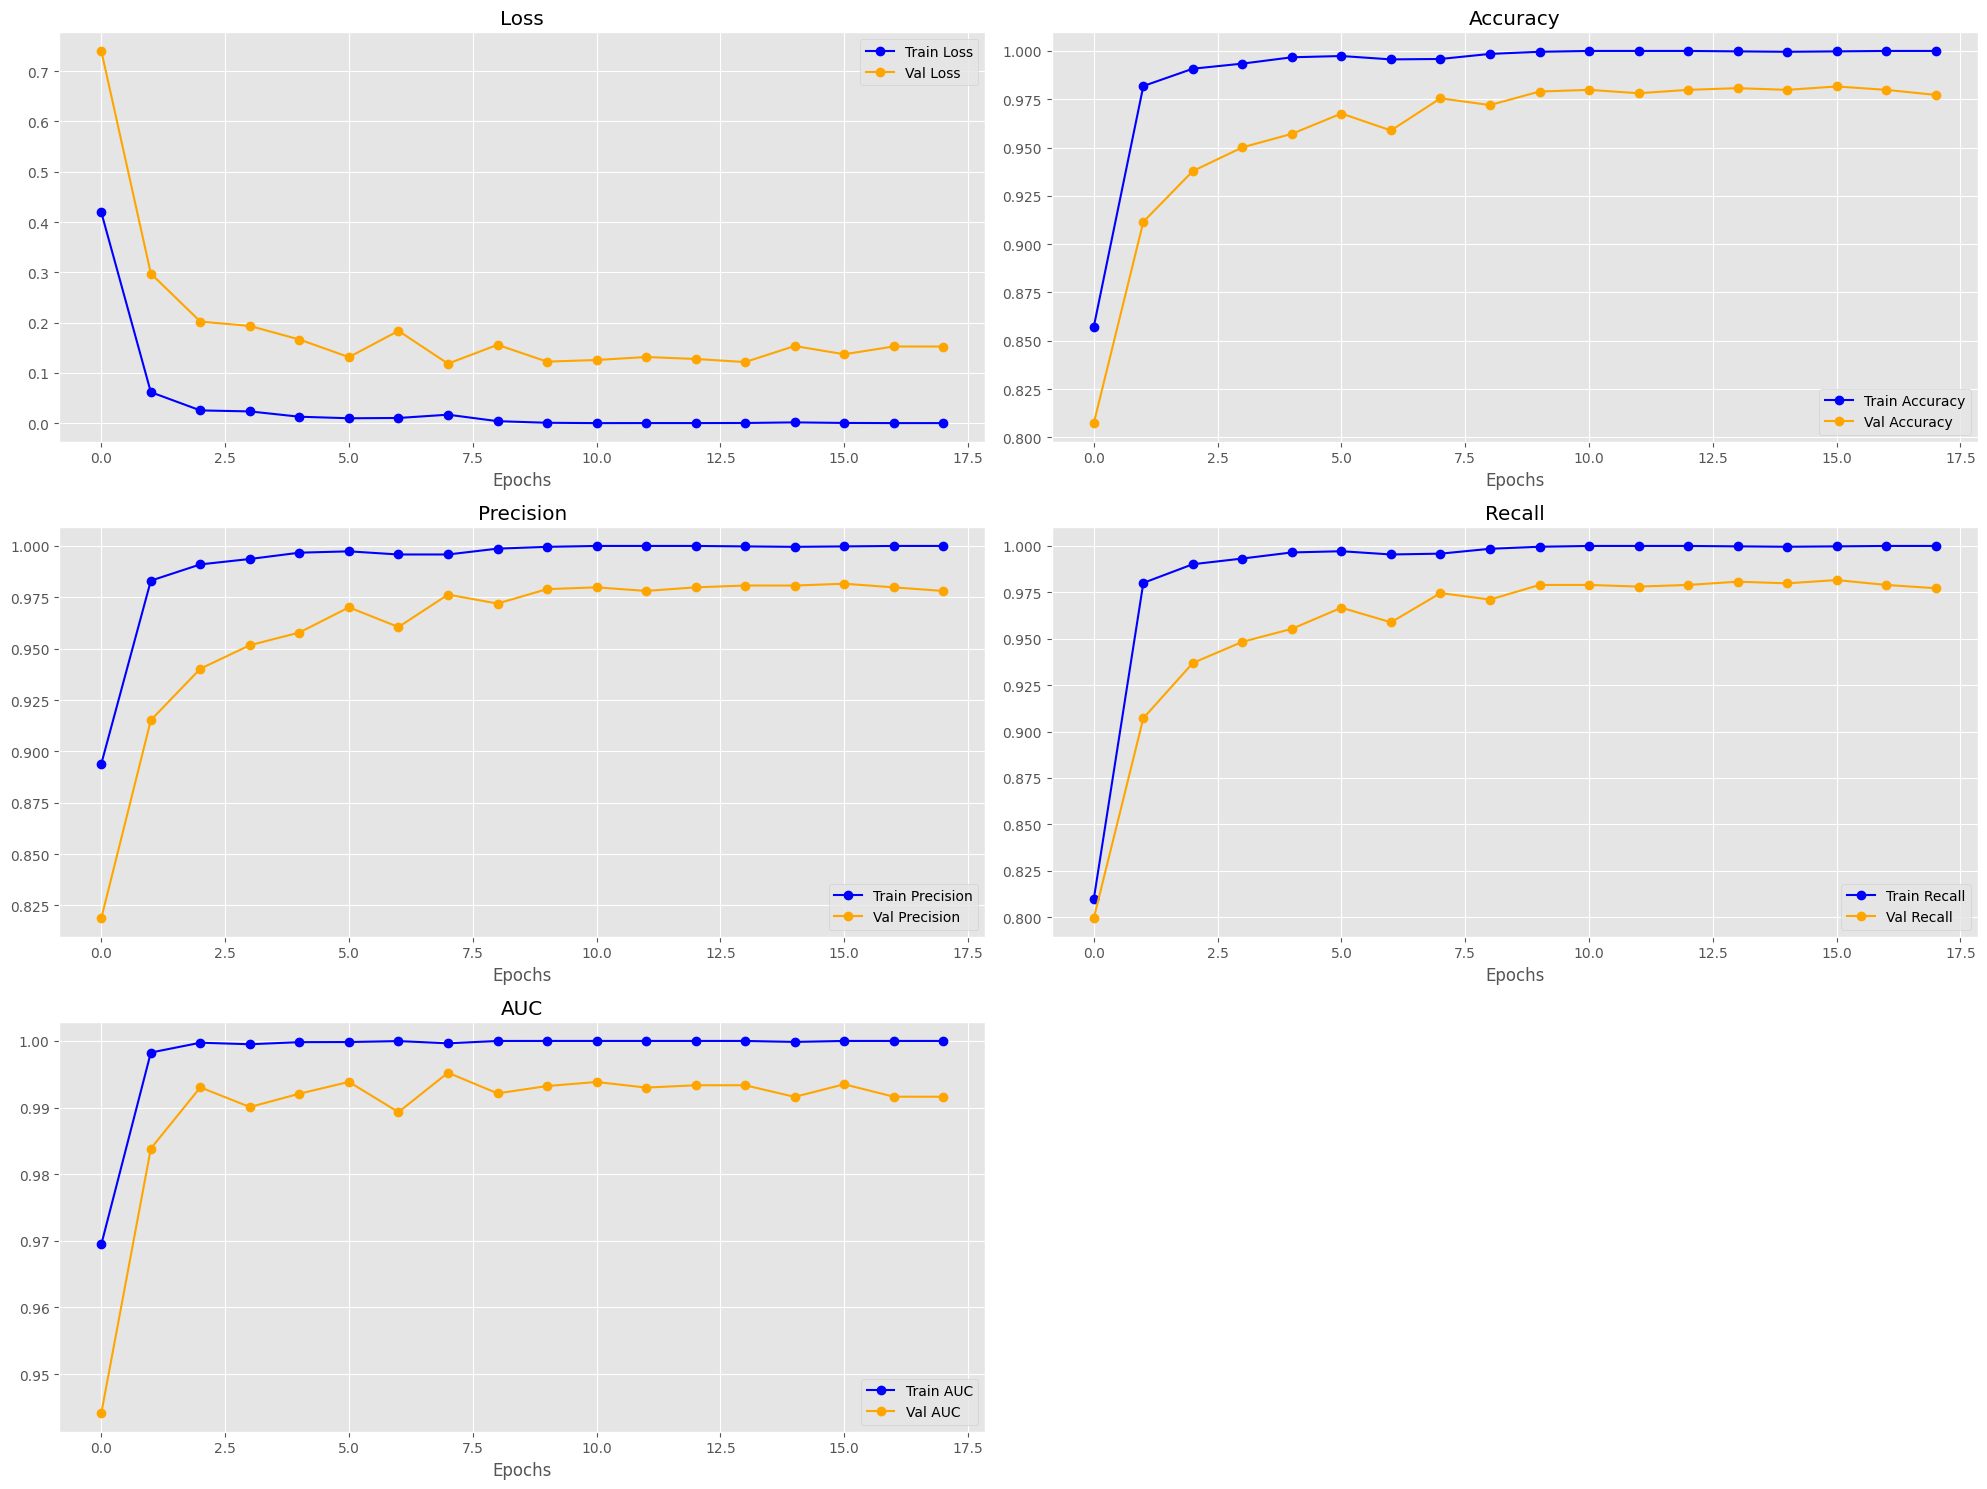

In [17]:
plot_curves(history)


In [18]:
model.evaluate(test_generator)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 584ms/step - accuracy: 0.9592 - auc: 0.9936 - loss: 0.1492 - precision: 0.9592 - recall: 0.9592


[0.09014377743005753,
 0.9771167039871216,
 0.9771167039871216,
 0.9771167039871216,
 0.9964004755020142]

21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.93      0.96       300
  meningioma       0.93      0.98      0.95       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.97      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



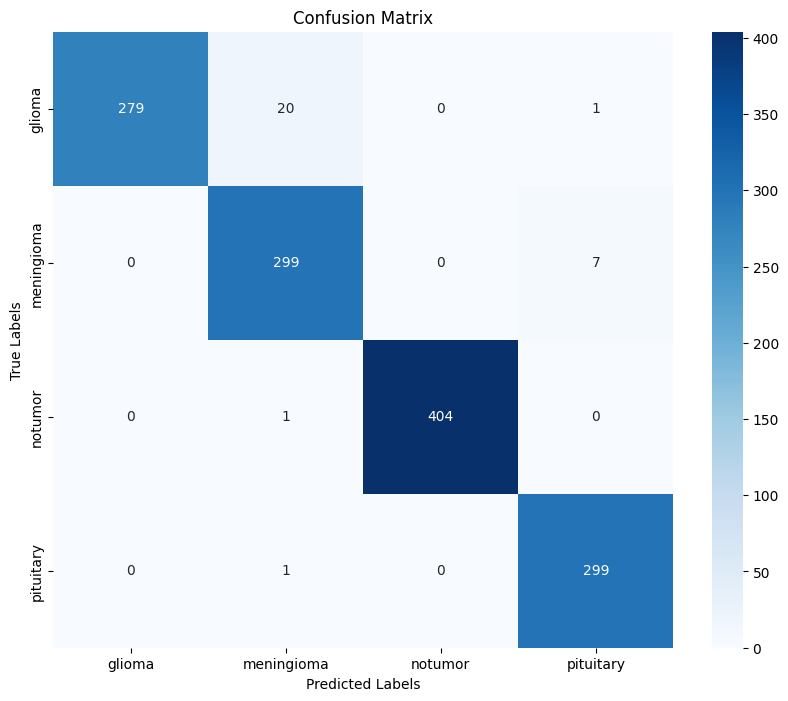

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


y_true = test_generator.classes 

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [18]:
del model, history

> <h2> EfficientNetB4</h2>

In [13]:
base_model = tf.keras.applications.EfficientNetB4(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False
    
model = tf.keras.models.Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(name='precision'),
                        Recall(name='recall'),
                       AUC(name='auc')])

model.build(input_shape=(None, 224, 224, 3))
model.summary()

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 1792)           │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       229,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,903,843 (68.30 MB)

 Trainable params: 17,778,636 (67.82 MB)

 Non-trainable params: 125,207 (489.09 KB)

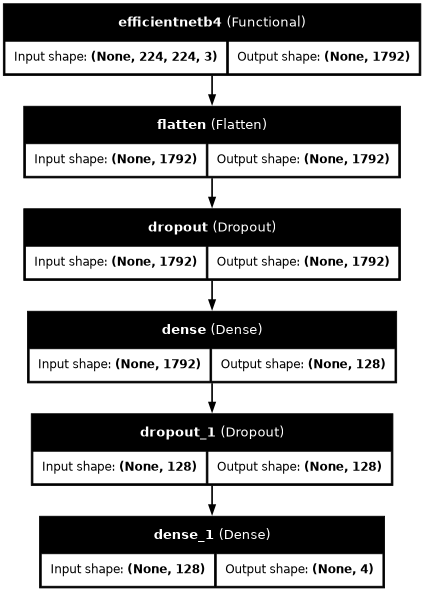

In [14]:
tf.keras.utils.plot_model(model, to_file='EfficientNetB4.png',show_shapes=True, dpi = 60, show_layer_names = True)

In [15]:
%%time
history = model.fit(train_generator, epochs = 50, validation_data = validation_generator, callbacks = [early_stopping, reduce_lr])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731073785.382780     110 service.cc:145] XLA service 0x78f1f00061f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731073785.382837     110 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731073935.343579     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 ━━━━━━━━━━━━━━━━━━━━ 432s 3s/step - accuracy: 0.6914 - auc: 0.8508 - loss: 1.9695 - precision: 0.7043 - recall: 0.6717 - val_accuracy: 0.2609 - val_auc: 0.4567 - val_loss: 2.9773 - val_precision: 0.2609 - val_recall: 0.2609 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 46s 607ms/step - accuracy: 0.9482 - auc: 0.9931 - loss: 0.1679 - precision: 0.9549 - recall: 0.9401 - val_accuracy: 0.2609 - val_auc: 0.4952 - val_loss: 2.5845 - val_precision: 0.2640 - val_recall: 0.2609 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 46s 612ms/step - accuracy: 0.9769 - auc: 0.9989 - loss: 0.0747 - precision: 0.9806 - recall: 0.9724 - val_accuracy: 0.2855 - val_auc: 0.6284 - val_loss: 1.4891 - val_precision: 0.3520 - val_recall: 0.2478 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 610ms/step - accuracy: 0.9859 - auc: 0.9992 - loss: 0.0451 - precision: 0.9888 - recall: 0.9853 - val_accuracy: 0.2837 - val_auc: 0.6643 - val_loss: 1.4669 - val_precisio

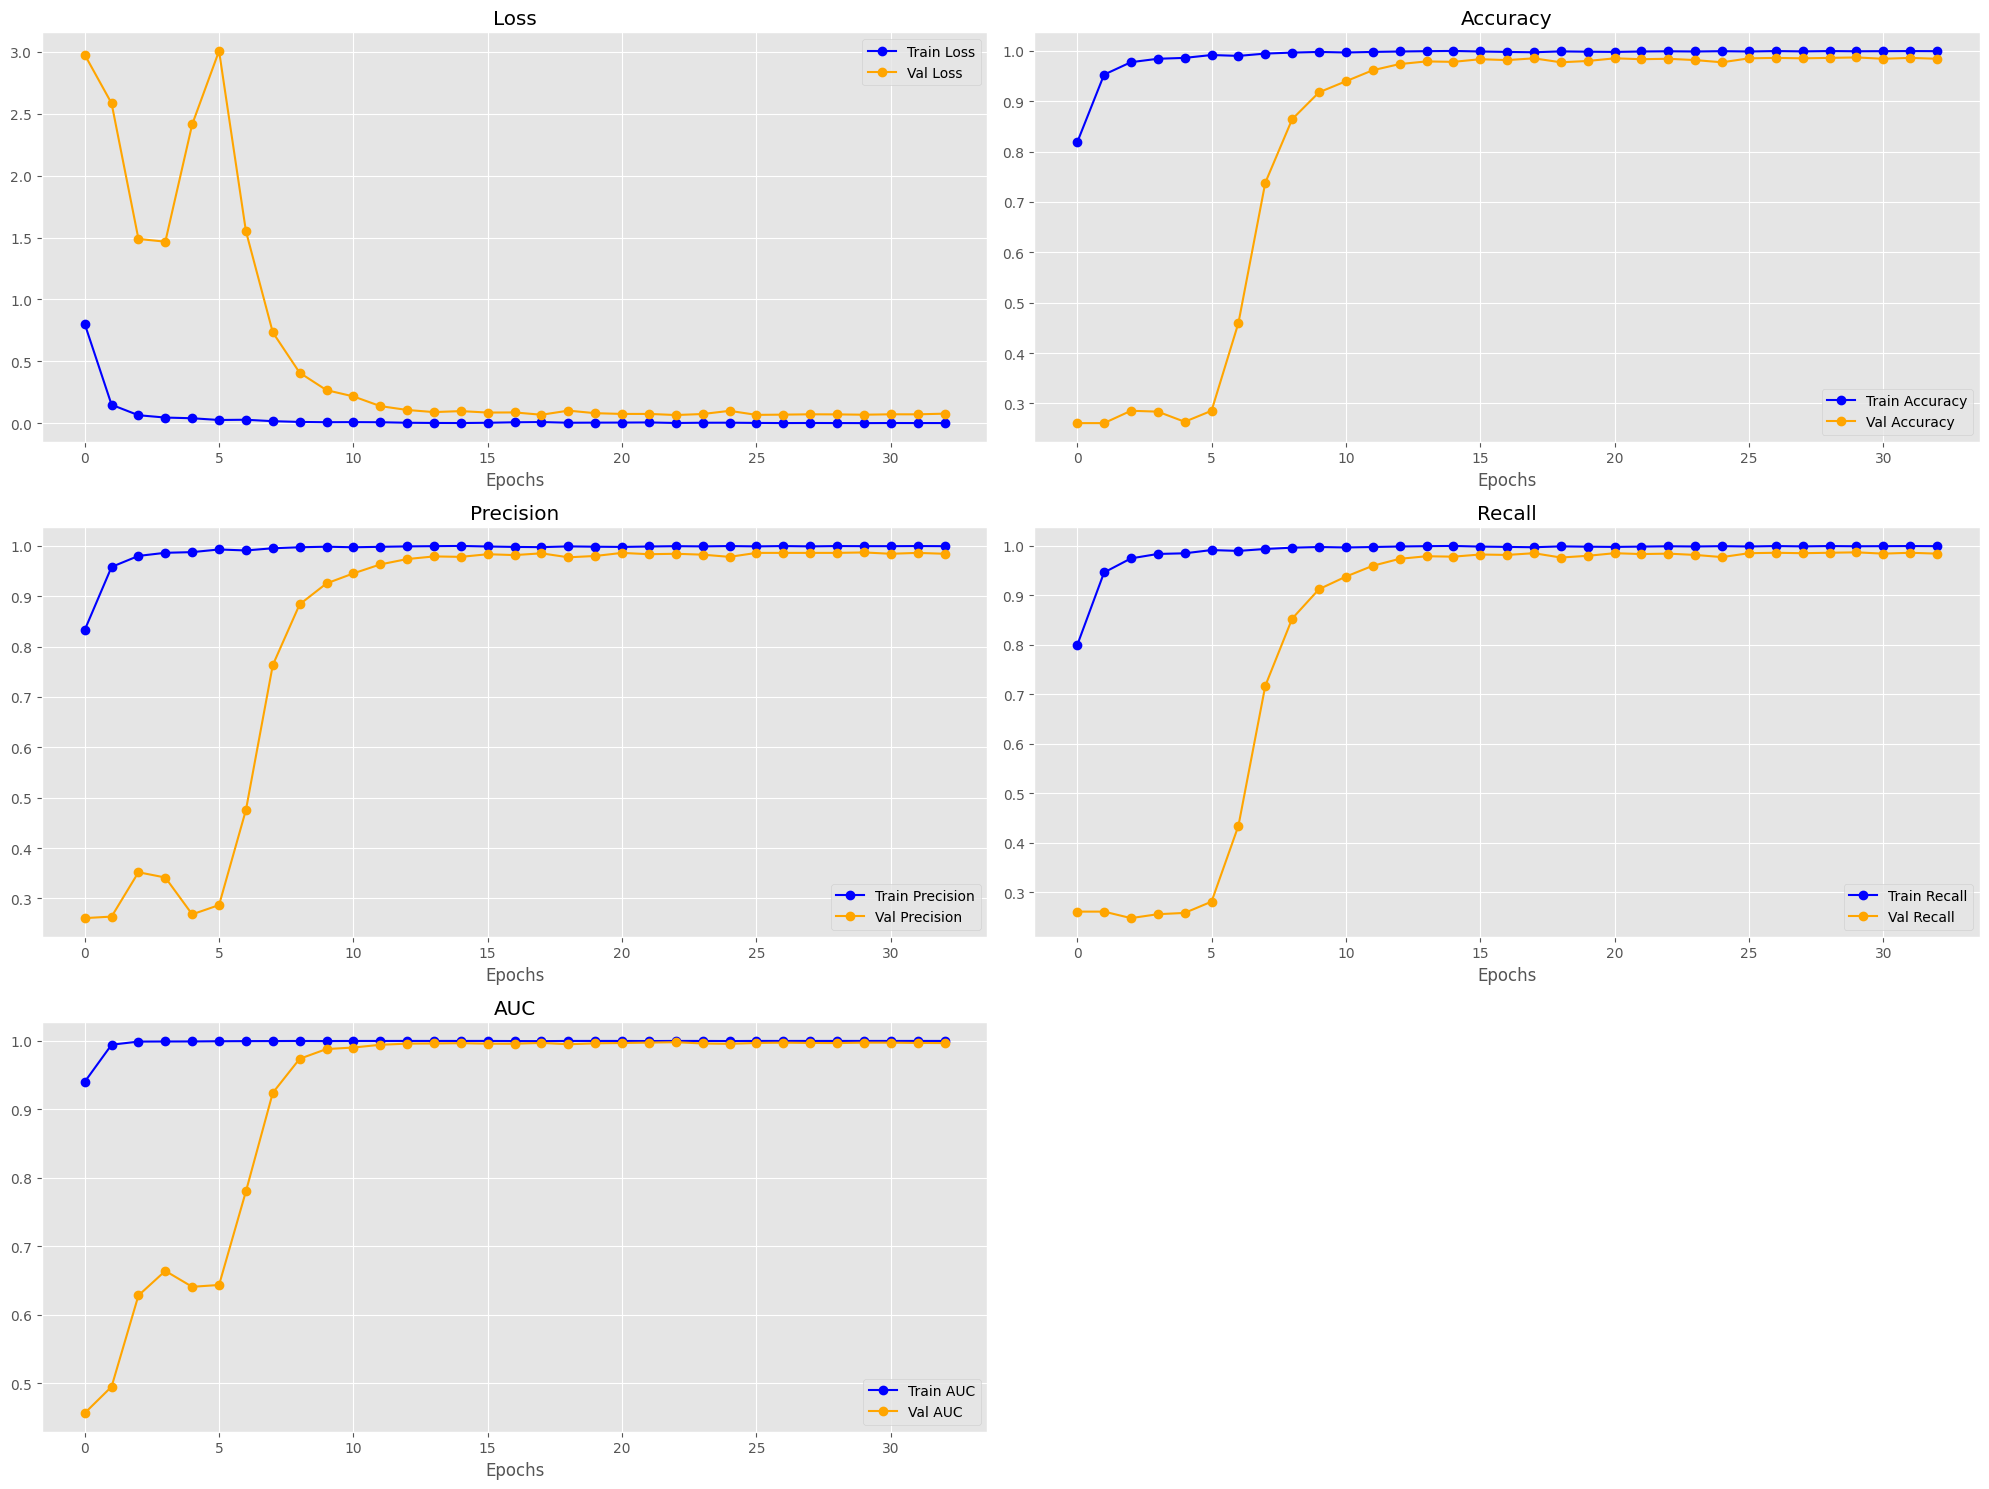

In [16]:
plot_curves(history)

In [ ]:
model.evaluate(test_generator)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/21 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step - accuracy: 0.9870 - auc: 0.9986 - loss: 0.0351 - precision: 0.9870 - recall: 0.9870

In [ ]:
del model, history

> <h2>ResNet-50</h2>

In [13]:
base_model = tf.keras.applications.ResNet50(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False
    
model = tf.keras.models.Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(name='precision'),
                        Recall(name='recall'),
                       AUC(name='auc')])

model.build(input_shape=(None, 224, 224, 3))
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 23,797,380 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

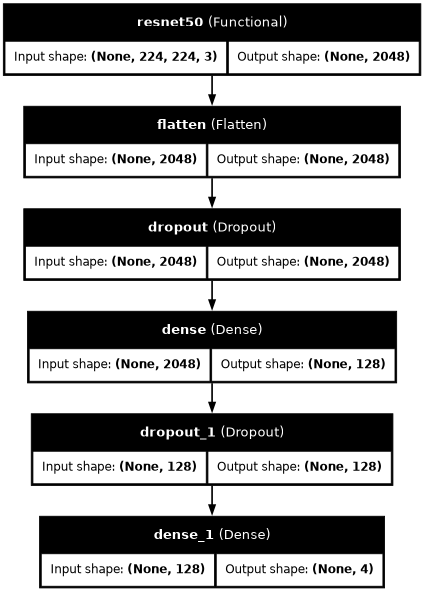

In [14]:
tf.keras.utils.plot_model(model, to_file='ResNet-50.png',show_shapes=True, dpi = 60, show_layer_names = True)

In [15]:
%%time
history = model.fit(train_generator, epochs = 50, validation_data = validation_generator, callbacks = [early_stopping, reduce_lr])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731075857.536854     108 service.cc:145] XLA service 0x7c446c00b230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731075857.536917     108 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731075894.256518     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.7089 - auc: 0.8564 - loss: 4.0488 - precision: 0.7233 - recall: 0.6894 - val_accuracy: 0.2242 - val_auc: 0.4557 - val_loss: 4.2107 - val_precision: 0.2242 - val_recall: 0.2242 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 353ms/step - accuracy: 0.9164 - auc: 0.9889 - loss: 0.2339 - precision: 0.9206 - recall: 0.9036 - val_accuracy: 0.2224 - val_auc: 0.4455 - val_loss: 2.6667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 372ms/step - accuracy: 0.9673 - auc: 0.9981 - loss: 0.0982 - precision: 0.9716 - recall: 0.9631 - val_accuracy: 0.2347 - val_auc: 0.4597 - val_loss: 2.6102 - val_precision: 0.2347 - val_recall: 0.2347 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 342ms/step - accuracy: 0.9775 - auc: 0.9991 - loss: 0.0634 - precision: 0.9783 - recall: 0.9758 - val_accuracy: 0.2347 - val_auc: 0.4644 - val_loss: 2.4123 - val_

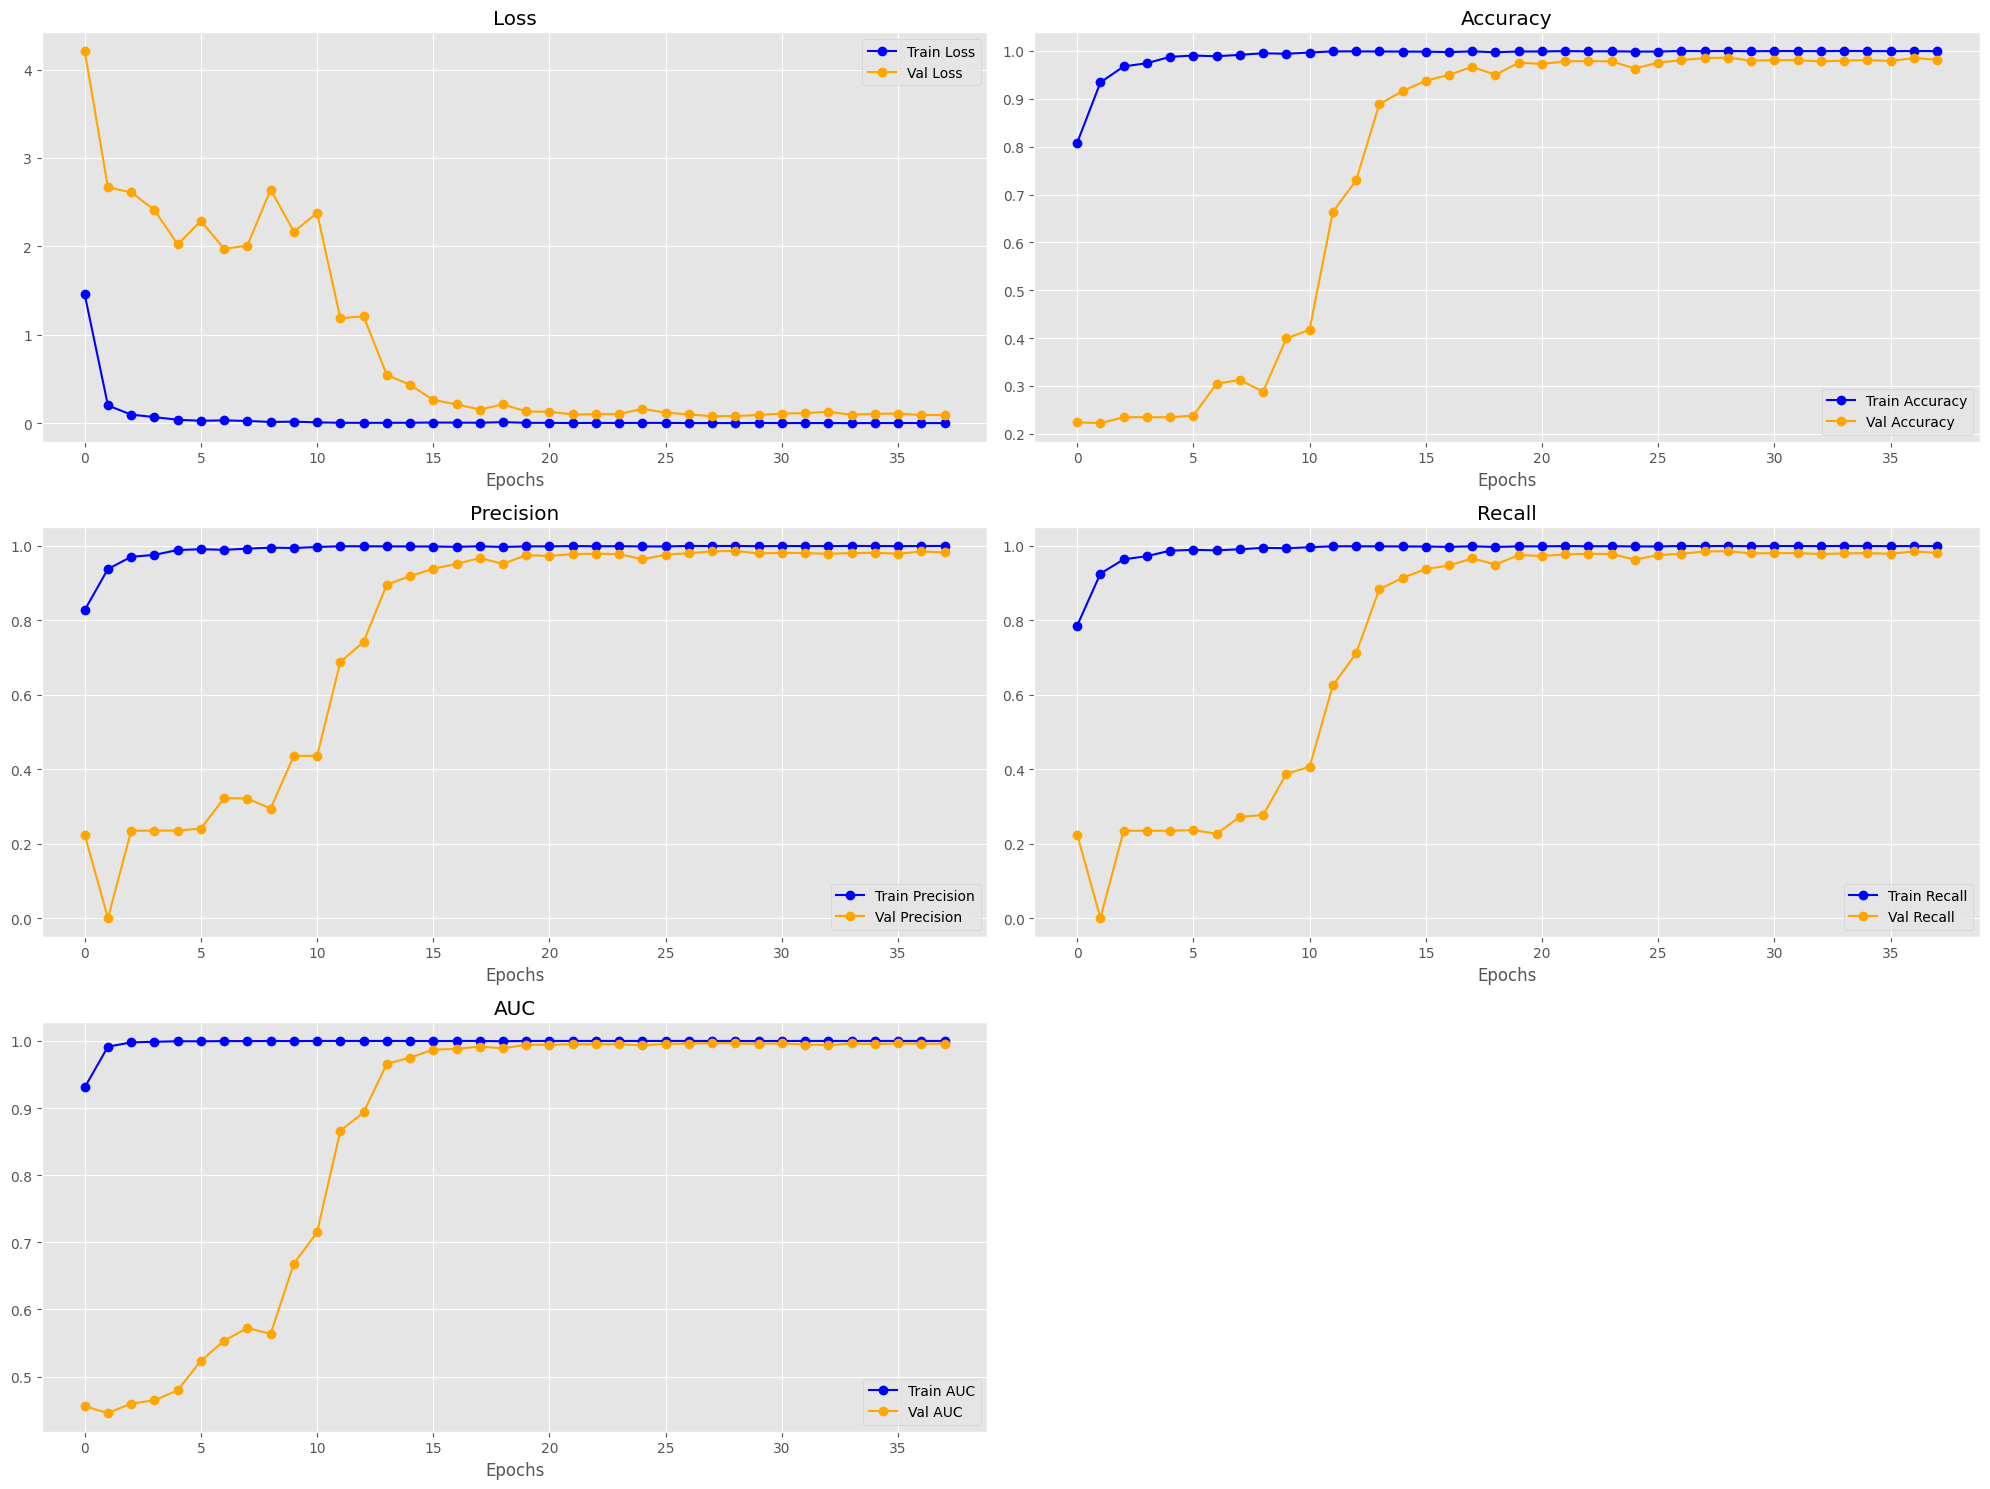

In [16]:
plot_curves(history)

In [ ]:
model.evaluate(test_generator)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/21 ━━━━━━━━━━━━━━━━━━━━ 6s 601ms/step - accuracy: 0.9794 - auc: 0.9951 - loss: 0.0860 - precision: 0.9794 - recall: 0.9794

In [ ]:
del model, history

> <h2>Custom Model</h2>

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Residual Block with L2 regularization
def residual_block(x, filters, kernel_size=3, stride=1, reg=1e-4):
    shortcut = x
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding="same", dilation_rate=(2, 2),
               kernel_regularizer=tf.keras.regularizers.l2(reg))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding="same", dilation_rate=(3, 3),
               kernel_regularizer=tf.keras.regularizers.l2(reg))(x)
    x = BatchNormalization()(x)
    
    # Adjust dimensions if necessary
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding="same")(shortcut)
    
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# CNN Model
def build_cnn(input_shape=(224, 224, 3), num_classes=4):
    inputs = Input(shape=input_shape)
    
    # Initial Convolutional Layers
    x = Conv2D(32, (3, 3), padding='same', activation='relu', dilation_rate=(2, 2))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Residual Block Layers
    x = residual_block(x, filters=64)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = residual_block(x, filters=128)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = residual_block(x, filters=256)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = residual_block(x, filters=512)
    
    # Global Pooling and Dense Layers
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.6)(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = Dropout(0.6)(x)
    
    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Build and compile the model
model = build_cnn()
model.compile(optimizer=Adamax(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')])

# Callbacks for learning rate reduction and early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Model Summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │    147,584 │ re_lu_2[0][0]   

 Total params: 5,018,180 (19.14 MB)

 Trainable params: 5,014,276 (19.13 MB)

 Non-trainable params: 3,904 (15.25 KB)

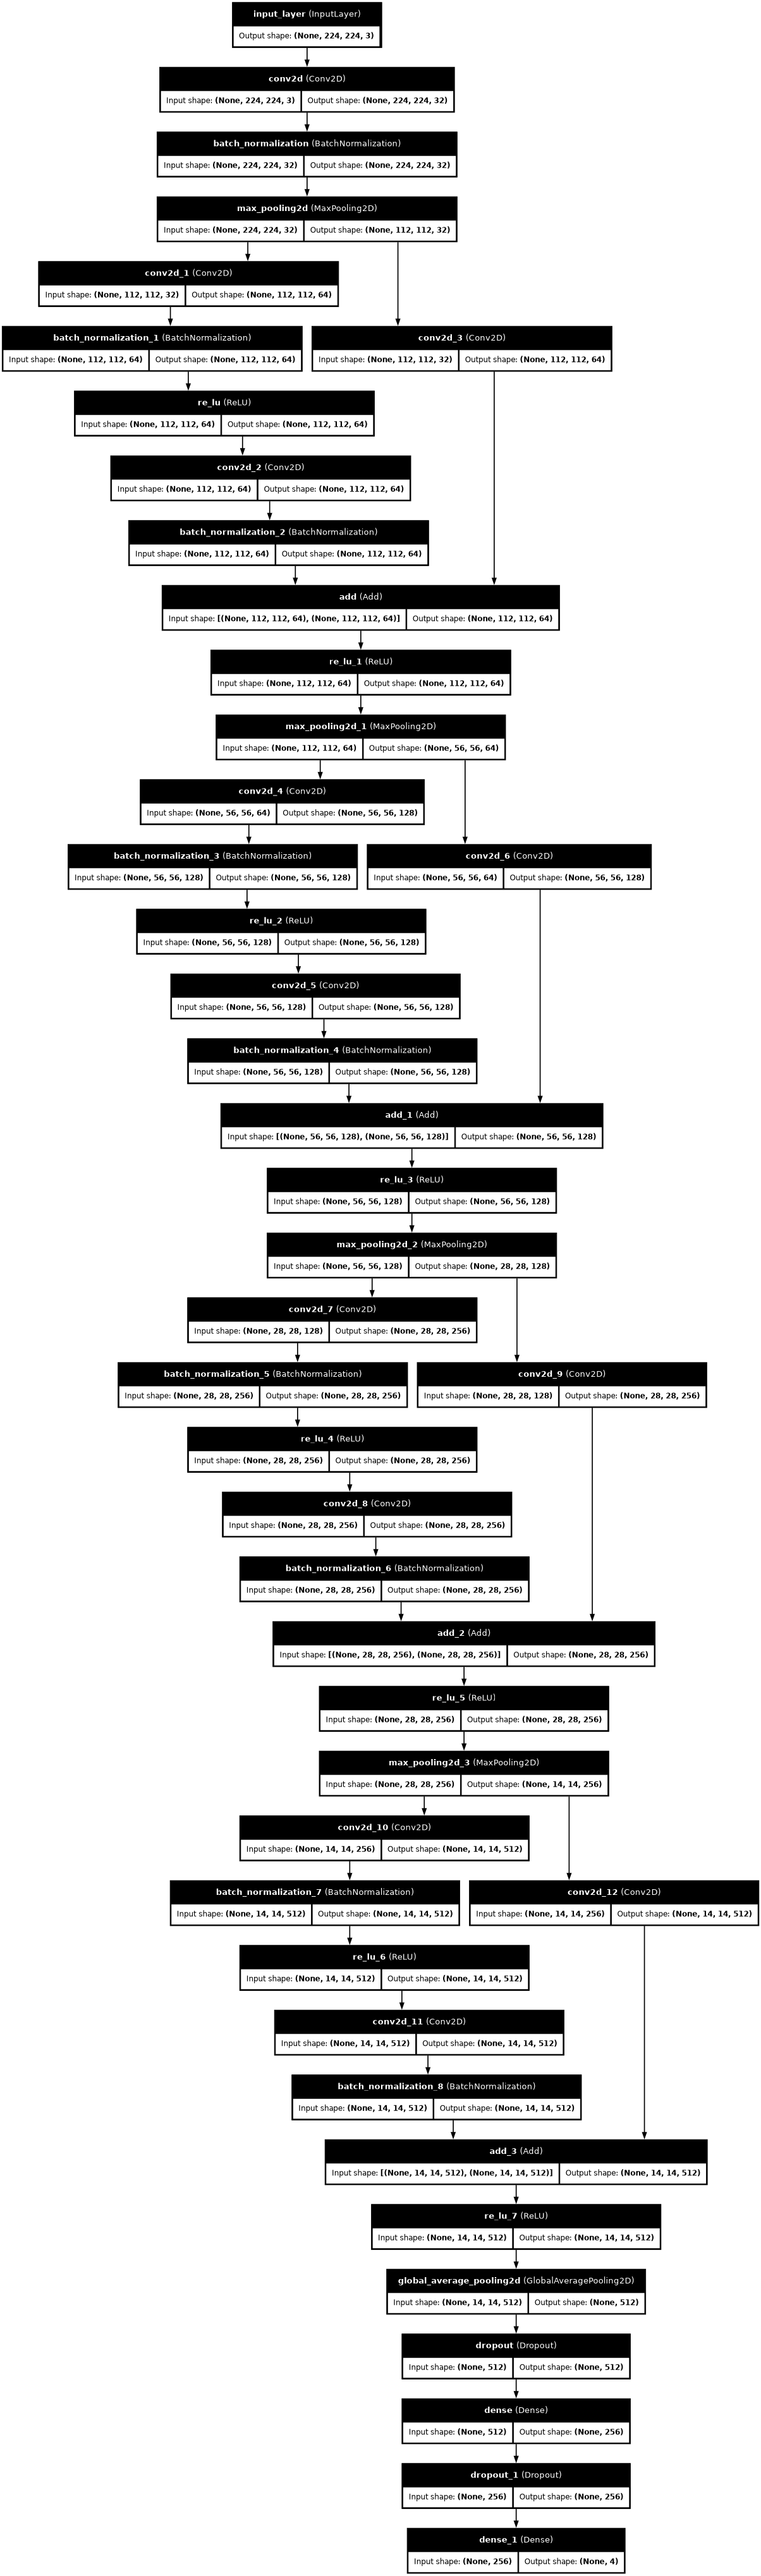

In [14]:
tf.keras.utils.plot_model(model, to_file='custom.png',show_shapes=True, dpi = 60, show_layer_names = True)

In [15]:
%%time
history = model.fit(train_generator, epochs = 50, validation_data = validation_generator, callbacks = [early_stopping, reduce_lr])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731570295.145259     105 service.cc:145] XLA service 0x7ad974002210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731570295.145336     105 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731570321.438795     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 ━━━━━━━━━━━━━━━━━━━━ 102s 911ms/step - accuracy: 0.5062 - auc: 0.7515 - loss: 1.5891 - precision: 0.5621 - recall: 0.4040 - val_accuracy: 0.2846 - val_auc: 0.5526 - val_loss: 1.7239 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 24s 306ms/step - accuracy: 0.7162 - auc: 0.9160 - loss: 0.8965 - precision: 0.7721 - recall: 0.6420 - val_accuracy: 0.2820 - val_auc: 0.6028 - val_loss: 2.5393 - val_precision: 0.2842 - val_recall: 0.2802 - learning_rate: 5.0000e-04
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 316ms/step - accuracy: 0.7810 - auc: 0.9430 - loss: 0.7696 - precision: 0.8195 - recall: 0.7294 - val_accuracy: 0.2802 - val_auc: 0.5413 - val_loss: 6.3611 - val_precision: 0.2807 - val_recall: 0.2802 - learning_rate: 5.0000e-04
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 23s 300ms/step - accuracy: 0.8184 - auc: 0.9585 - loss: 0.6801 - precision: 0.8429 - recall: 0.7835 - val_accuracy: 0.3739 - val_auc: 0.5879 - val_loss

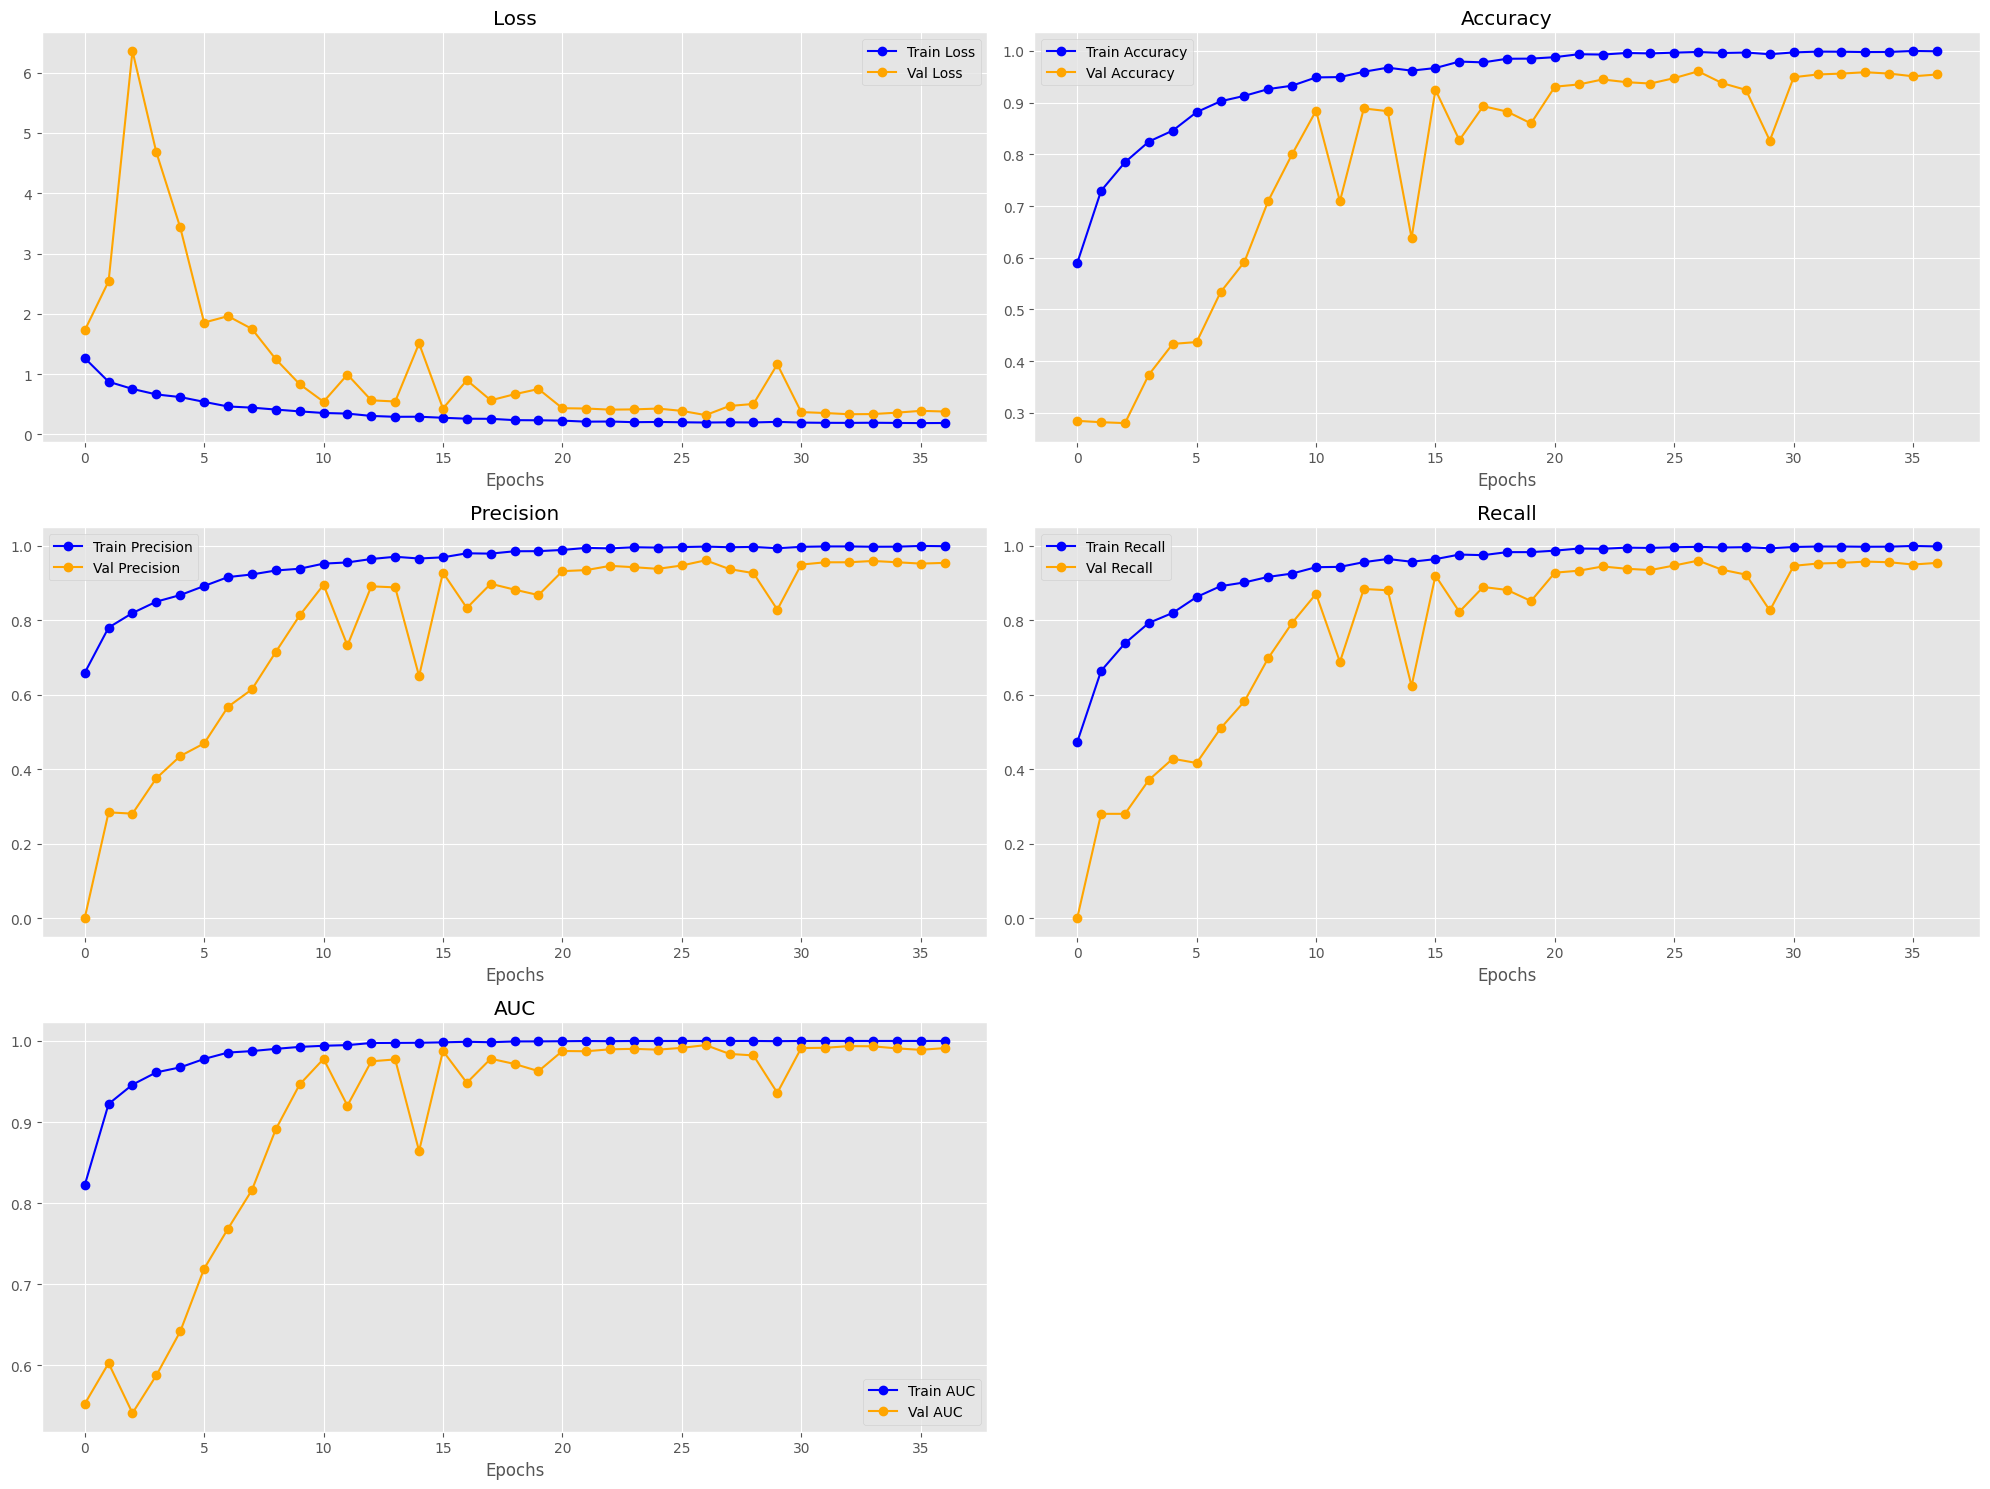

In [16]:
plot_curves(history)

In [17]:
model.evaluate(test_generator)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 651ms/step - accuracy: 0.9548 - auc: 0.9906 - loss: 0.3723 - precision: 0.9548 - recall: 0.9548


[0.29979991912841797,
 0.9710144996643066,
 0.9710144996643066,
 0.9710144996643066,
 0.9953160881996155]

21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.94      0.97       300
  meningioma       0.94      0.94      0.94       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



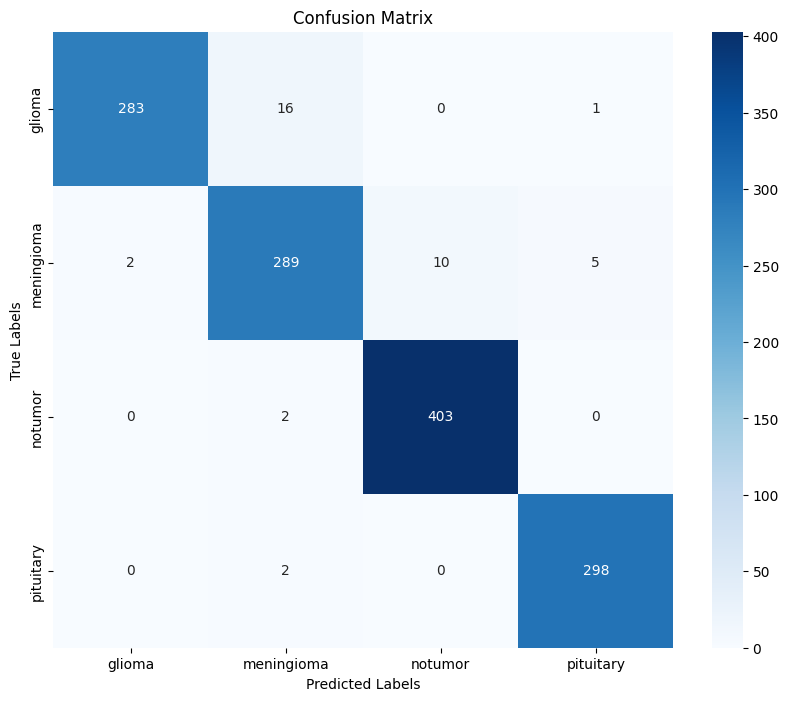

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


y_true = test_generator.classes 

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


> <h2>U-net</h2>

In [13]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Input, GlobalAveragePooling2D, Dense, BatchNormalization, SpatialDropout2D, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.models import Sequential

model = Sequential([
    # Input tensor shape
    Input(shape=img_shape),
    
    # Convolutional layer 1 with Batch Normalization
    Conv2D(64, (4, 4), activation="relu", dilation_rate=(3, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 2 with Batch Normalization
    Conv2D(64, (4, 4), activation="relu", dilation_rate=(3, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 3 with Batch Normalization
    Conv2D(128, (3, 3), activation="relu", dilation_rate=(2, 2)),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4 with Batch Normalization
    Conv2D(128, (3, 3), activation="relu", dilation_rate=(2, 2)),
    MaxPooling2D(pool_size=(2, 2)),

    # Additional Convolutional layer (New) with Batch Normalization
    Conv2D(256, (2, 2), activation="relu", dilation_rate=(1, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolution layer 5 with Batch Normalization
    Conv2D(256, (2, 2), activation="relu", dilation_rate=(1, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Dense layers
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dense(4, activation="softmax")
])

# Compile the model with specified optimizer and metrics
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 215, 215, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 107, 107, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 98, 98, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 256)      │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 819,588 (3.13 MB)

 Trainable params: 818,564 (3.12 MB)

 Non-trainable params: 1,024 (4.00 KB)

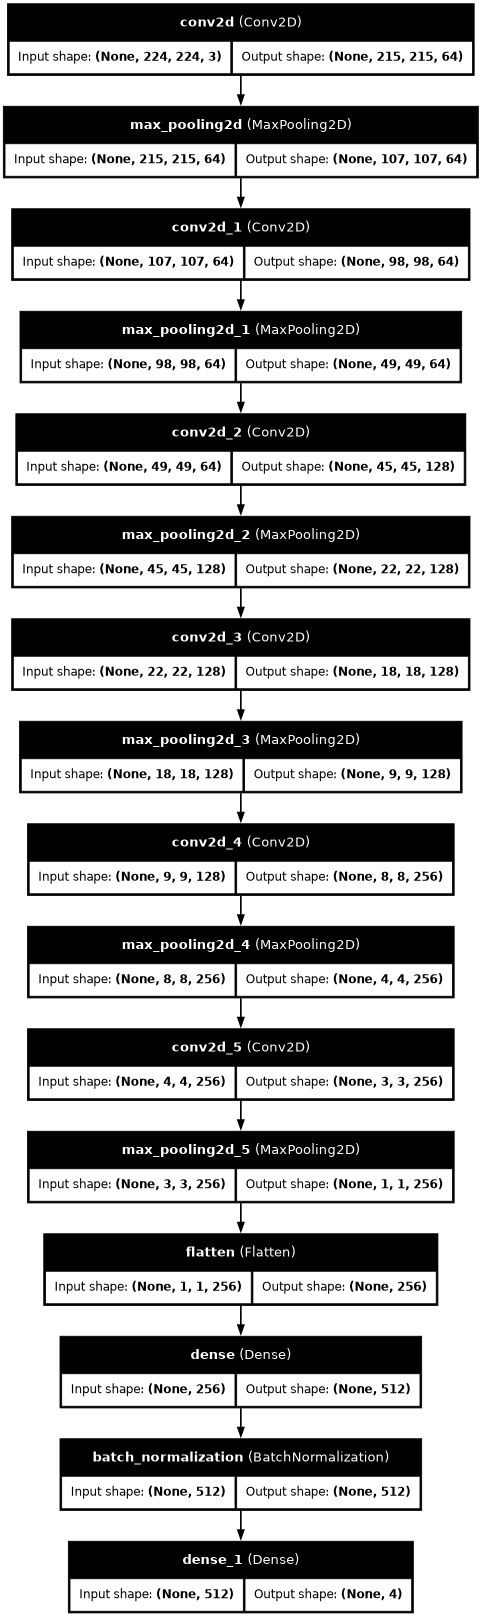

In [14]:
tf.keras.utils.plot_model(model, to_file='custom-2.png',show_shapes=True, dpi = 60, show_layer_names = True)

In [15]:
%%time
history = model.fit(train_generator, epochs = 50, validation_data = validation_generator, callbacks = [early_stopping, reduce_lr])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731392268.572513     110 service.cc:145] XLA service 0x79dfb4002c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731392268.572590     110 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/72 ━━━━━━━━━━━━━━━━━━━━ 19:20 16s/step - accuracy: 0.4688 - auc: 0.6747 - loss: 1.3306 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1731392277.624621     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 ━━━━━━━━━━━━━━━━━━━━ 69s 735ms/step - accuracy: 0.6293 - auc: 0.8484 - loss: 0.9339 - precision: 0.7472 - recall: 0.4272 - val_accuracy: 0.4308 - val_auc: 0.6900 - val_loss: 1.2451 - val_precision: 0.9536 - val_recall: 0.1261 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 24s 302ms/step - accuracy: 0.7940 - auc: 0.9478 - loss: 0.5627 - precision: 0.8381 - recall: 0.7319 - val_accuracy: 0.2627 - val_auc: 0.7425 - val_loss: 1.3395 - val_precision: 0.2823 - val_recall: 0.2469 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 24s 310ms/step - accuracy: 0.8588 - auc: 0.9714 - loss: 0.4051 - precision: 0.8839 - recall: 0.8331 - val_accuracy: 0.5245 - val_auc: 0.8500 - val_loss: 0.9575 - val_precision: 0.7309 - val_recall: 0.3687 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 316ms/step - accuracy: 0.9035 - auc: 0.9865 - loss: 0.2777 - precision: 0.9196 - recall: 0.8890 - val_accuracy: 0.7294 - val_auc: 0.9109 - val_loss: 0.7612 - val_precis

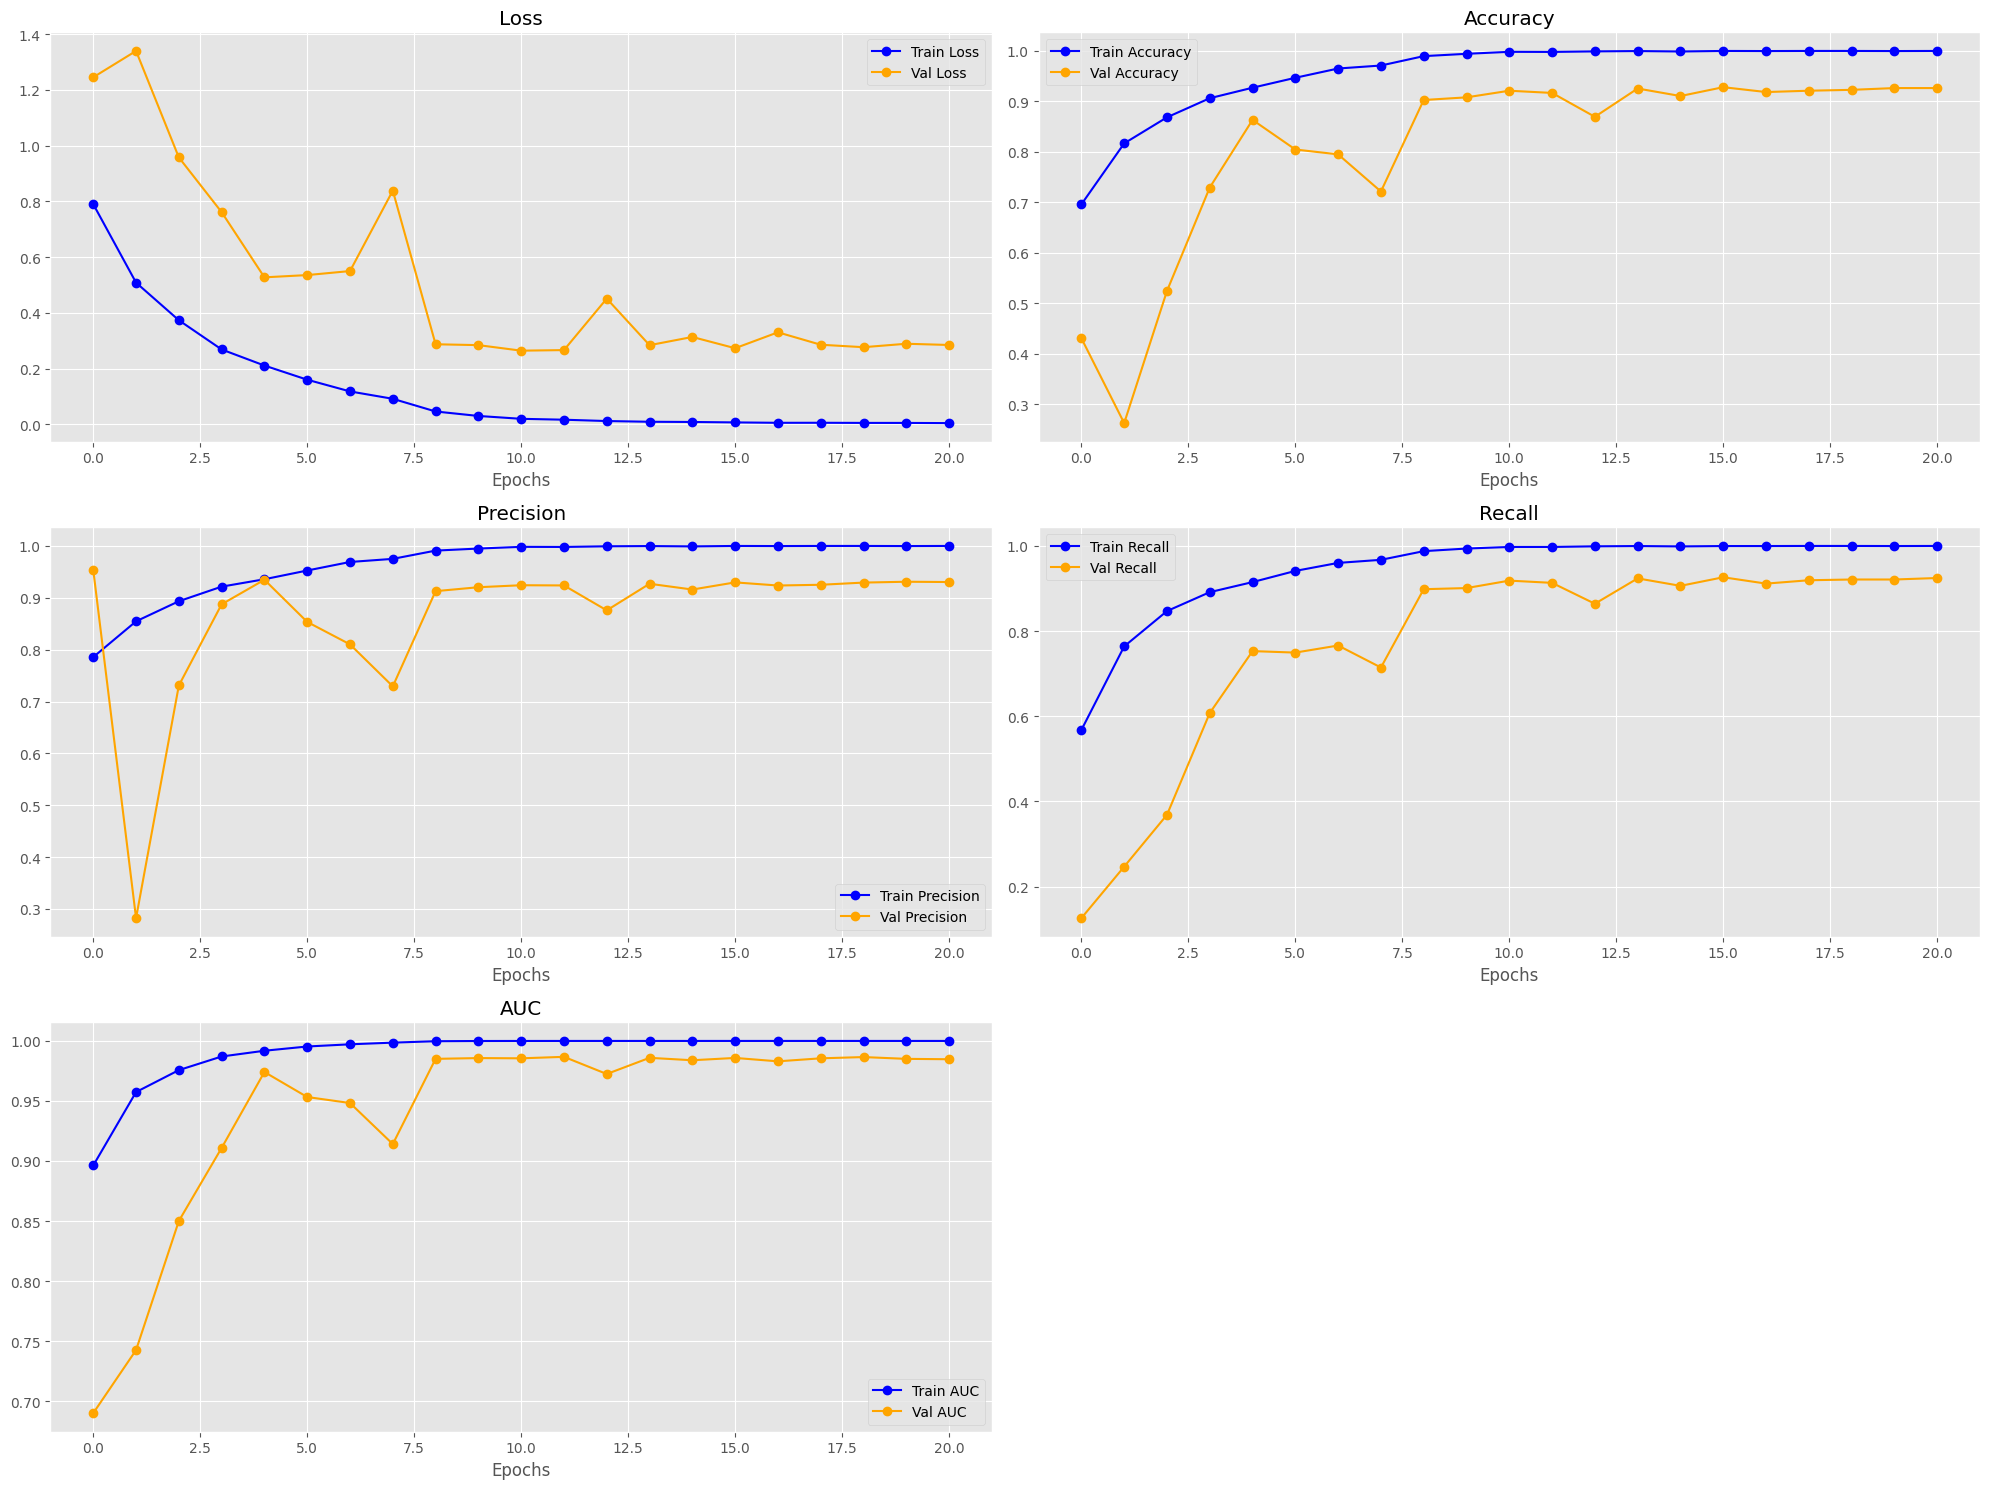

In [16]:
plot_curves(history)

In [17]:
model.evaluate(test_generator)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 493ms/step - accuracy: 0.9172 - auc: 0.9857 - loss: 0.2501 - precision: 0.9216 - recall: 0.9101


[0.16161289811134338,
 0.9488939642906189,
 0.9516128897666931,
 0.9450801014900208,
 0.9931338429450989]

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.96      0.89      0.93       300
  meningioma       0.90      0.90      0.90       306
     notumor       0.97      1.00      0.99       405
   pituitary       0.95      0.99      0.97       300

    accuracy                           0.95      1311
   macro avg       0.95      0.94      0.95      1311
weighted avg       0.95      0.95      0.95      1311



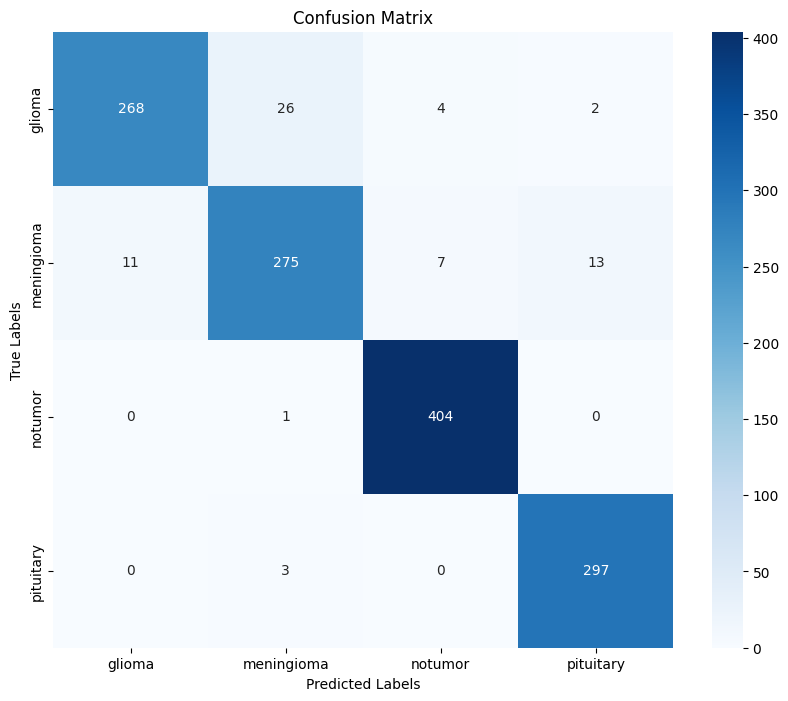

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


y_true = test_generator.classes 

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
